# Random Sample K Means Cluster

What this demo does:

- Samples N random text embeddings from wiki dataset, gets 3 models' cluster similarity for those vectors as demonstrated in ```./kmeans.ipynb```
- Take cluster similarity between all three models
- Serves as a baseline of cluster invariance across embeddings models
- Can easily be extendable to a loss function evaluated at the batch level in a translation model as follows:
    - Embed ```b``` vectors using source and target model, where ```b``` = batch size. Translate vectors using MLP.
    - Cluster the target embeddings vectors and generated translated embeddings vectors, evaluate loss using the k-Means similarity technique described in ```./kmeans.ipynb```.


All of the following procedures are effectively the same as in ```./kmeans.ipynb```, but using a random sample from the wikipedia dataset. 

#### Load + merge data

In [44]:
import numpy as np
import pandas as pd 

fns=['./data/oawikishort.csv','./data/sbertDf.csv','./data/mpnetDf.csv']
modelNames=['OpenAI (ada02)','SBERT','MPNet']

openAI=pd.read_csv(fns[0])
openAI['content_vector'] = openAI['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=','))

sbert=pd.read_csv(fns[1])
sbert['content_vector'] = sbert['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

mpnet=pd.read_csv(fns[2])
mpnet['content_vector'] = mpnet['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

In [45]:
openAI=openAI.rename(columns={"content_vector": "openai"})
sbert=sbert.rename(columns={"content_vector": "sbert"})
mpnet=mpnet.rename(columns={"content_vector": "mpnet"})
df=openAI.join(sbert.set_index('text'), on='text')
df=df.join(mpnet.set_index('text'), on='text')

#### Sample n samples, embed, cluster

In [46]:
#sample 100 rows
joinedDf=df.sample(n=1000,)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming joinedDf is already defined with 'text', 'mpnet', and 'sbert' columns
joinedDf['mpnet'] = joinedDf['mpnet'].apply(np.array)
joinedDf['sbert'] = joinedDf['sbert'].apply(np.array)
joinedDf['openai'] = joinedDf['openai'].apply(np.array)


# Function to find the optimal number of clusters using silhouette score
def optimal_clusters(data):
    silhouette_scores = []
    for k in range(2, 21):
        kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_k = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    return optimal_k

# Find optimal clusters for mpnet and sbert embeddings
optimal_k_mpnet = optimal_clusters(np.stack(joinedDf['mpnet']))
optimal_k_sbert = optimal_clusters(np.stack(joinedDf['sbert']))
optimal_k_openai = optimal_clusters(np.stack(joinedDf['openai']))

#we take the minimum of the two optimal clusters, as the best alignment tends to be at the minimum k value 
min_k = min(optimal_k_mpnet, optimal_k_sbert, optimal_k_openai)

# KMeans clustering with optimal number of clusters
kmeans_mpnet = KMeans(n_clusters=min_k, random_state=42,n_init=10)
joinedDf['mpnet_cluster'] = kmeans_mpnet.fit_predict(np.stack(joinedDf['mpnet']))

kmeans_sbert = KMeans(n_clusters=min_k, random_state=42,n_init=10)
joinedDf['sbert_cluster'] = kmeans_sbert.fit_predict(np.stack(joinedDf['sbert']))

kmeans_openai = KMeans(n_clusters=min_k, random_state=42,n_init=10)
joinedDf['openai_cluster'] = kmeans_openai.fit_predict(np.stack(joinedDf['openai']))

# Create pairwise contingency matrices
contingency_matrix_mpnet_sbert = pd.crosstab(joinedDf['mpnet_cluster'], joinedDf['sbert_cluster'])
contingency_matrix_sbert_openai = pd.crosstab(joinedDf['sbert_cluster'], joinedDf['openai_cluster'])
contingency_matrix_openai_mpnet = pd.crosstab(joinedDf['openai_cluster'], joinedDf['mpnet_cluster'])

# Calculate pairwise alignment scores
alignment_score_mpnet_sbert = contingency_matrix_mpnet_sbert.max(axis=1).sum() / joinedDf.shape[0]
alignment_score_sbert_openai = contingency_matrix_sbert_openai.max(axis=1).sum() / joinedDf.shape[0]
alignment_score_openai_mpnet = contingency_matrix_openai_mpnet.max(axis=1).sum() / joinedDf.shape[0]

# Print the pairwise contingency matrices and alignment scores
print("Contingency Matrix (MPNet vs SBERT):\n", contingency_matrix_mpnet_sbert)
print("\nCluster Alignment Score (MPNet vs SBERT):", alignment_score_mpnet_sbert)

print("\nContingency Matrix (SBERT vs OpenAI):\n", contingency_matrix_sbert_openai)
print("\nCluster Alignment Score (SBERT vs OpenAI):", alignment_score_sbert_openai)

print("\nContingency Matrix (OpenAI vs MPNet):\n", contingency_matrix_openai_mpnet)
print("\nCluster Alignment Score (OpenAI vs MPNet):", alignment_score_openai_mpnet)

Contingency Matrix (MPNet vs SBERT):
 sbert_cluster  0   1   2   3   4   5   6   7   8   9   10  11  12
mpnet_cluster                                                    
0               2   0  38   0   3   1  18  15   4   3   0   4   0
1               2   2   1   0  46   0   6  70   2   9   4  50   0
2               0   0   0  40   0   0   5   0   0   0   0   0   0
3               0   0   1   0   1   0   0   0   0  41   0   1   2
4               1   0   0   0   0  93   0   0   0   1   1   0   1
5               1   0   4   0   6   3   0   0  47   0   0   1   4
6              51   0   0  13   1   0   2   0   0   1   9   0   0
7               0   0   9   0   4   2   0   0   1   2   0   0  77
8               4  26   0   0  12   3  12   2   2   0   3   2  11
9               2   5   1   2   5   0   8   4   0   0  28   1   0
10              1   2   1   0  10   1   1   9   8   2   0  38   0
11              0   5   1   0   5   0   0   4  24   0   1   0   0
12              0   0   1   2   0   0 

#### Construct t-SNE projection, visualize.

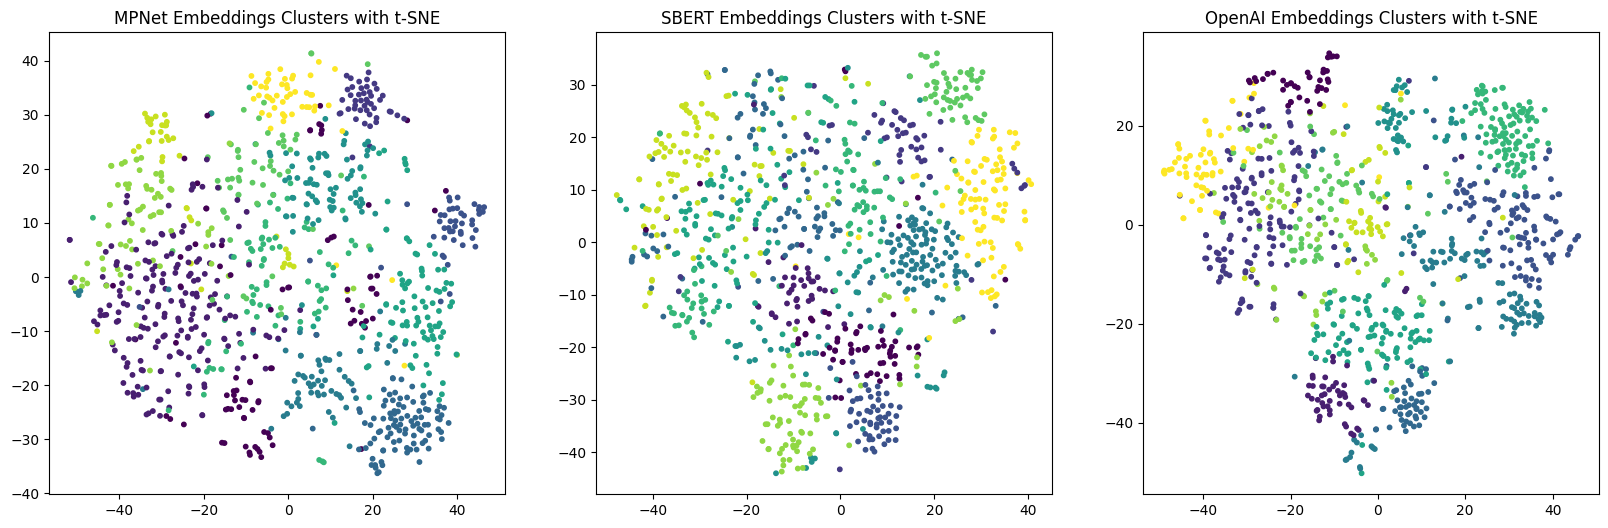

In [47]:
# Create a color mapping based on the contingency matrix
num_clusters = min_k 
color_mapping = []

# t-SNE for dimensionality reduction to 2D
tsne_model = TSNE(n_components=2, random_state=42)

# Projecting mpnet embeddings to 2D
mpnet_2d = tsne_model.fit_transform(np.stack(joinedDf['mpnet']))

# Projecting sbert embeddings to 2D
sbert_2d = tsne_model.fit_transform(np.stack(joinedDf['sbert']))

# Projecting openai embeddings to 2D
openai_2d = tsne_model.fit_transform(np.stack(joinedDf['openai']))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot for mpnet clusters with corresponding colors
axes[0].scatter(mpnet_2d[:, 0], mpnet_2d[:, 1], c=joinedDf['mpnet_cluster'], cmap='viridis', s=10)
axes[0].set_title('MPNet Embeddings Clusters with t-SNE')

# Plot for sbert clusters with corresponding colors
axes[1].scatter(sbert_2d[:, 0], sbert_2d[:, 1], c=joinedDf['sbert_cluster'], cmap='viridis', s=10)
axes[1].set_title('SBERT Embeddings Clusters with t-SNE')

# Plot for openai clusters with corresponding colors
axes[2].scatter(openai_2d[:, 0], openai_2d[:, 1], c=joinedDf['openai_cluster'], cmap='viridis', s=10)
axes[2].set_title('OpenAI Embeddings Clusters with t-SNE')

plt.show()